# Classification des Revenus avec XGBoost sur le Jeu de Données Adult
Ce notebook présente un projet de science des données responsable visant à prédire si une personne gagne plus de 50 000 $ (`>50K`) par an en utilisant le jeu de données **Adult**. Nous utiliserons **XGBoost**, un algorithme d'apprentissage supervisé basé sur les arbres de décision, pour effectuer cette classification.

In [8]:

!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
import shap

%matplotlib inline

In [10]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]
# Charger les données depuis un fichier CSV
data = pd.read_csv('adult.data', header=None, names=column_names,na_values=" ?")
print(data.head(40))

                                              age         workclass  \
Name                DOB        SSN            Zip         Workclass   
Karrie Trusslove    9/7/1967   732-14-6110  64152         State-gov   
Brandise Tripony    6/7/1988   150-19-2766  61523  Self-emp-not-inc   
Brenn McNeely       8/6/1991   725-59-9860  95668           Private   
Dorry Poter         4/6/2009   659-57-4974  25503           Private   
Dick Honnan         9/16/1951  220-93-3811  75387           Private   
Allene Raff         8/2/2001   535-53-2336   9820           Private   
Clevie Schimoni     10/17/1989 787-78-1258  87125           Private   
Erhard Nesbeth      7/25/1971  208-67-0874  60887  Self-emp-not-inc   
Hedvige Fairpo      8/10/2001  691-69-7317  81548           Private   
Kally Ayers         7/31/1998  632-53-4141  51592           Private   
Binni Mc Mechan     6/23/2009  119-26-4980  90245           Private   
Hedda Allworthy     6/14/1995  232-09-2296  89259         State-gov   
Massim

In [11]:
data.info()
missing_percentage = data.isnull().mean() * 100

# Afficher les résultats
print("Pourcentage de valeurs manquantes par colonne :")
print(missing_percentage)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 32564 entries, ('Name', 'DOB', 'SSN') to ('Hortense Hardesty', '5/11/2012', '690-42-5638')
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32564 non-null  object
 1   workclass       30728 non-null  object
 2   fnlwgt          32564 non-null  object
 3   education       32564 non-null  object
 4   education_num   32564 non-null  object
 5   marital_status  30721 non-null  object
 6   occupation      32564 non-null  object
 7   relationship    32564 non-null  object
 8   race            32564 non-null  object
 9   sex             32564 non-null  object
 10  capital_gain    31981 non-null  object
 11  capital_loss    32564 non-null  object
 12  hours_per_week  32564 non-null  object
 13  native_country  32564 non-null  object
 14  income          32564 non-null  object
dtypes: object(15)
memory usage: 7.1+ MB
Pourcentage de valeurs manquantes par

In [12]:
print(data.isnull().sum())
# Supprimer les lignes contenant des valeurs manquantes
data = data.dropna()

print(f"Nombre de lignes restantes : {len(data)}")
print(data.isnull().sum())


age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status    1843
occupation           0
relationship         0
race                 0
sex                  0
capital_gain       583
capital_loss         0
hours_per_week       0
native_country       0
income               0
dtype: int64
Nombre de lignes restantes : 30165
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [13]:
# Imputer les valeurs manquantes
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')
imputer = SimpleImputer(strategy='most_frequent')
data[categorical_features] = imputer.fit_transform(data[categorical_features])

In [34]:
# Binarisation de l'âge
median_age = data['age'].median()
print(median_age)
data['age_binary'] = data['age'].apply(lambda x: 'Young' if x <= median_age else 'Old')
data = data.drop('age', axis=1)

TypeError: could not convert string to float: 'Zip'

In [35]:
# Prétraitement des variables catégorielles et numériques
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# Séparer les caractéristiques et la cible
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

In [ ]:

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Afficher les proportions
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de validation : {len(X_val)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")


Taille de l'ensemble d'entraînement : 21716
Taille de l'ensemble de validation : 5429
Taille de l'ensemble de test : 3017


In [ ]:
# Pipeline avec XGBoost
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
clf_pipeline.fit(X_train, y_train)

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      2266
           1       0.77      0.68      0.72       751

    accuracy                           0.87      3017
   macro avg       0.83      0.80      0.82      3017
weighted avg       0.86      0.87      0.87      3017

Exactitude : 0.8684
F1 Score : 0.7186


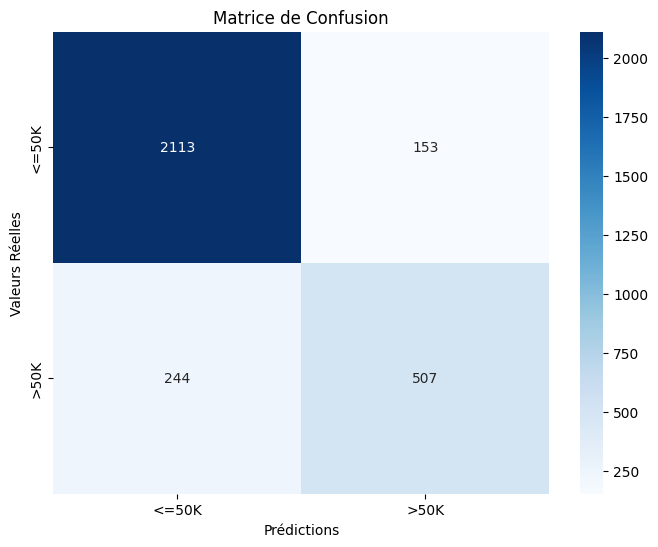

In [ ]:


# Prédire les résultats sur l'ensemble de test
y_pred = clf_pipeline.predict(X_test)

# Imprimer le rapport de classification
print("Rapport de Classification :\n", classification_report(y_test, y_pred))
print(f"Exactitude : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une heatmap pour visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


# Test for part 1

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045

Rapport de Classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045

Exactitude : 1.0000
F1 Score : 0.0000


/home/plouis/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/plouis/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


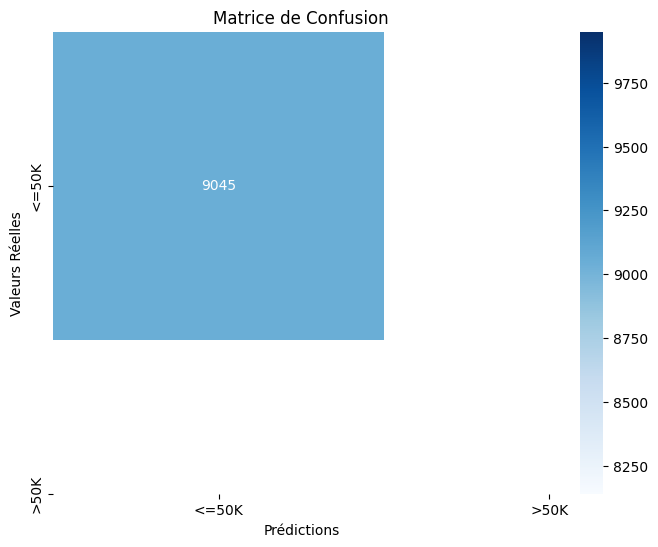

In [62]:

from aif360.datasets import AdultDataset
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from aif360.algorithms.preprocessing import Reweighing

# Define the custom preprocessing function
def custom_preprocessing(df):
    median_age = df['age'].median()
    df['age_binary'] = df['age'].apply(lambda x: 1 if x <= median_age else 0)
    df = df.drop('age', axis=1)
    return df

# Load the dataset with the custom preprocessing
dataset_orig = AdultDataset(
    custom_preprocessing=custom_preprocessing,
    protected_attribute_names=['age_binary', 'sex', 'race'], 
    privileged_classes=[[1], ['Male'], ['White']]
)

privileged_groups = [{'age_binary': 1, 'sex': 1}]  # Old males
unprivileged_groups = [{'age_binary': 0, 'sex': 0}]  # Young females
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig)

# Convert dataset to pandas DataFrame for compatibility with XGBoost
df, _ = dataset_transf_train.convert_to_dataframe()

# Separate features (X) and target variable (y)
X = df.drop(columns=['income-per-year'])  # Replace 'income-per-year' with the actual target column name
y = df['income-per-year'].apply(lambda x: 1 if x == '>50K' else 0)  # Binary encoding for target variable

# Handle missing data (if any)
df.fillna(df.median(), inplace=True)  # Example: Replace missing values with column medians

# Proper train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(eval_metric='logloss')  # Remove use_label_encoder

# Train the model
xgb_classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


# Imprimer le rapport de classification
print("Rapport de Classification :\n", classification_report(y_test, y_pred))
print(f"Exactitude : {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Créer une heatmap pour visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


# Part 2 : Fairness of the classifier

### Importation of needed libraires

In [19]:
import numpy as np
np.random.seed(42)

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import AdultDataset , BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from IPython.display import Markdown, display

In [48]:
print(AdultDataset())

               instance weights features                                    \
                                                       protected attribute   
                                     age education-num                race   
instance names                                                               
0                           1.0     25.0           7.0                 0.0   
1                           1.0     38.0           9.0                 1.0   
2                           1.0     28.0          12.0                 1.0   
3                           1.0     44.0          10.0                 0.0   
5                           1.0     34.0           6.0                 1.0   
...                         ...      ...           ...                 ...   
48837                       1.0     27.0          12.0                 1.0   
48838                       1.0     40.0           9.0                 1.0   
48839                       1.0     58.0           9.0          

Step 2 Load dataset, specifying protected attribute, and split dataset into train and test

In [20]:
#import pandas as pd
#from aif360.datasets import BinaryLabelDataset

# Load the dataset produced from part 1
#train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
#train_data = train_data.dropna()
# Est ce que c'est une alternative de faire 
# data = pd.read_csv('path_to_your_processed_data.csv')

# This filters the columns of the train_data to include only those columns that have numeric data types.
#train_data = train_data.select_dtypes(include=['number'])

# Specify protected attributes
#protected_attributes = ['age_binary', 'sex']

# Split the dataset into train and test sets
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['income'])

# Create BinaryLabelDataset for train and test sets
#train_dataset = BinaryLabelDataset(
#    df=train_data,
#    label_names=['income'],
#    protected_attribute_names=protected_attributes
#)

#test_dataset = BinaryLabelDataset(
#    df=test_data,
#    label_names=['income'],
#    protected_attribute_names=protected_attributes
#)


In [21]:
# We want to difine a custom preprocesing function (custom_preprocessing(df)) from the standat dataset class 
# that will be used to transform the dataset
def custom_preprocessing(df):
    median_age = df['age'].median()
    df['age_binary'] = df['age'].apply(lambda x: 1 if x <= median_age else 0)
    df = df.drop('age', axis=1)
    return df
# So what we did is to add a new column 'age_binary' to the dataset and drop the 'age' column, in order to 
# binarise the age column.

# Load the dataset with the library aif360
dataset_orig = AdultDataset(custom_preprocessing=custom_preprocessing,
                          protected_attribute_names=['age_binary', 'sex','race'], # race will remain because in the original library is defined with this protecte attribute
                          privileged_classes=[[1], ['Male'],['White']]) # We supposed that the privileged class is the old white male. It's also defined like this in the original library


Step 3 Compute fairness metric on original training dataset
The fairness metric is Statistical Parity Difference whitch measures the disparity in positive outcomes between unprivileged and privileged groups. It compares the probability of receiving a positive outcome for members of the unprivileged group against that for members of the privileged group.

In [22]:
# Define the privileged and unprivileged groups in order to compute the disparate impact
privileged_groups = [{'age_binary': 1, 'sex': 1}]  # Old males
unprivileged_groups = [{'age_binary': 0, 'sex': 0}]  # Young females

In [23]:
# Compute the fairness metric statistical parity measure, which is the difference in the mean prediction between the unprivileged and privileged groups.
# A negative value indicates less favorable outcomes for the unprivileged groups. in order to see if the dataset is biased
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.015898


As it can be seen from the privious cell, we conclude that there is a bias in this dataset because the statistical paity metric is not equal to zero. More specifficaly, in the unprivileged group we have 2% of peopele are suffering of unfairness.  

 Step 4 Mitigate bias by transforming the original dataset via technique to ensure the classifier is fair. Here we want to use the Pre-Processing method Reweighting for fairness. This method will simply assigns weights to samples to balance the representation of protected groups in the training process.

In [24]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig)

In [25]:
print('The 50 first instance weights originally:')
dataset_orig.instance_weights[:50]

The 50 first instance weights originally:


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
print('The 50 first instance weights after reweighing:')
dataset_transf_train.instance_weights[:50]

The 50 first instance weights after reweighing:


array([0.91752147, 1.        , 1.37514924, 1.        , 0.91752147,
       1.        , 1.        , 1.        , 1.        , 0.91752147,
       1.        , 1.        , 1.        , 0.91752147, 0.90006666,
       1.        , 1.37514924, 1.        , 0.91752147, 0.91752147,
       1.        , 0.91752147, 0.91752147, 1.        , 0.91752147,
       1.        , 0.90006666, 0.91752147, 0.91752147, 1.        ,
       1.37514924, 0.91752147, 0.91752147, 0.91752147, 1.        ,
       1.        , 0.91752147, 0.91752147, 0.91752147, 1.        ,
       1.        , 1.        , 0.90006666, 0.90006666, 0.91752147,
       1.        , 1.        , 1.37514924, 1.        , 1.        ])

We can clearly see from the cell above that the reweight method of transforming the dataset into a fair one worked.


Step 5 Compute fairness metric on transformed dataset


In [27]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


Step 6: Comparision between the classifier and the fair classifier

In [58]:
# Convert dataset to pandas DataFrame for compatibility with XGBoost
df, _ = dataset_orig.convert_to_dataframe()

# Extract features and labels
X = df.drop(columns=['income-per-year'])  # Replace 'income-per-year' with the actual target column name
y = df['income-per-year'].apply(lambda x: 1 if x == '>50K' else 0)  # Binary encoding for target variable


# Split the dataset into train and test sets for the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Extract features and labels for the transformed dataset
Xt = dataset_transf_train.features
yt = dataset_transf_train.labels.ravel()

# Split the transformed dataset into train and test sets
X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(Xt, yt, test_size=0.3, shuffle=True)





In [ ]:
# Pipeline with XGBoost
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

clf_pipeline.fit(X_train, y_train)
# Prediction
y_pred = clf_pipeline.predict(X_test)

ValueError: A given column is not a column of the dataframe

In [ ]:
# Pipeline with XGBoost
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
clf_pipeline.fit(X_train, y_train)
# Prediction
y_pred = clf_pipeline.predict(X_test)

In [ ]:
#Comparaison between the original and the fair dataset

In [60]:
from aif360.datasets import AdultDataset
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from aif360.algorithms.preprocessing import Reweighing

# Define the custom preprocessing function
def custom_preprocessing(df):
    median_age = df['age'].median()
    df['age_binary'] = df['age'].apply(lambda x: 1 if x <= median_age else 0)
    df = df.drop('age', axis=1)
    return df

# Load the dataset with the custom preprocessing
dataset_orig = AdultDataset(
    custom_preprocessing=custom_preprocessing,
    protected_attribute_names=['age_binary', 'sex', 'race'], 
    privileged_classes=[[1], ['Male'], ['White']]
)

privileged_groups = [{'age_binary': 1, 'sex': 1}]  # Old males
unprivileged_groups = [{'age_binary': 0, 'sex': 0}]  # Young females
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig)

# Convert dataset to pandas DataFrame for compatibility with sklearn pipeline
df, _ = dataset_transf_train.convert_to_dataframe()

# Separate features (X) and target variable (y)
X = df.drop(columns=['income-per-year'])  # Replace 'income-per-year' with the actual target column name
y = df['income-per-year'].apply(lambda x: 1 if x == '>50K' else 0)  # Binary encoding for target variable

# Define preprocessing steps
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define pipeline with preprocessing and XGBClassifier
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the pipeline
clf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = clf_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9045

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



/home/plouis/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:54:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
